('3.8.0-CAPI-1.13.1 ', (3, 8, 0), (1, 13, 1))
0.20652554318920785
0.1906657899399215
0.30013591928270367
0.4090321411593839
0.30397163573183217
0.4913293052977124


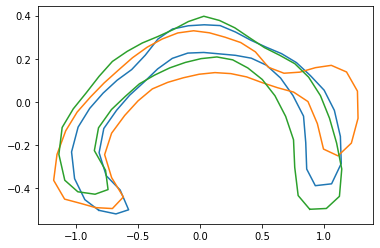

In [49]:
import numpy as np
import matplotlib.pyplot as pp
import os
from shapely.geometry import Polygon
from shapely.validation import make_valid
import shapely.geos
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score 

print(shapely.geos._geos_version())

def plot_shape(data):
    pp.plot(data[:, 0], data[:, 1])

def plot_shapes(path):
    for nm in os.listdir(path):
        f = open(os.path.join(path, nm))
        data = np.loadtxt(f, delimiter=',')
        plot_shape(data)

    pp.show()
    
    
# plot_shapes('corpus_callosum/healthy/50/')
# plot_shapes('corpus_callosum/altzheimers/50/')

s1 = np.loadtxt('corpus_callosum/healthy/50/1.txt', delimiter=',')
s2 = np.loadtxt('corpus_callosum/healthy/50/2.txt', delimiter=',')
s3 = np.loadtxt('corpus_callosum/healthy/50/3.txt', delimiter=',')
plot_shape(s1)
plot_shape(s2)
plot_shape(s3)

s1[-1] = s1[0]
s2[-1] = s2[0]
s3[-1] = s3[0]

p1 = Polygon(s1)
p2 = Polygon(s2)
p3 = Polygon(s3)

print(p1.hausdorff_distance(p2))
print(p1.hausdorff_distance(p3))
print(p2.hausdorff_distance(p3))

def area_dist(p1, p2):
    return p1.symmetric_difference(p2).area

print(area_dist(p1, p2))
print(area_dist(p1, p3))
print(area_dist(p2, p3))

In [94]:
def load_polygons(path):
    polygons = []
    for nm in os.listdir(path):
        f = open(os.path.join(path, nm))
        data = np.loadtxt(f, delimiter=',')
        data[-1] = data[0]
        polygons.append(Polygon(data))
    return polygons

def load_data(path):
    data = []
    for nm in os.listdir(path):
        f = open(os.path.join(path, nm))
        line = np.loadtxt(f, delimiter=',')
        line[-1] = line[0]
        data.append(line.flatten())
    return np.array(data)

97 314


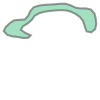

In [39]:
a = load_polygons('corpus_callosum/altzheimers/50/')
b = load_polygons('corpus_callosum/healthy/50/')
print(len(a), len(b))
a[10]

In [10]:
# for make_valid, clone shapely's git, work in the main directory . so that shapely is in ./shapely
# This is because we need GEOS >= 3.8, which is only supported in shapely >= 1.7.1 (?)
# For the GEOS library, use sudo apt install libgeos-dev.

In [44]:
def objective_function(x, polygons):
    x = x.reshape((-1, 2))
    x[-1] = x[0]
    p = Polygon(x)
    p = make_valid(p)
    areas = []
    return sum(area_dist(p, q) for q in polygons) / len(polygons)


print(objective_function(s1, ps))
print(objective_function(s2, ps))
print(objective_function(s3, ps))

0.24604063765305811
0.37661521683958454
0.3803314426792778


Optimization terminated successfully.
         Current function value: 0.223482
         Iterations: 6
         Function evaluations: 815
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.217040
         Iterations: 3
         Function evaluations: 509
         Gradient evaluations: 5


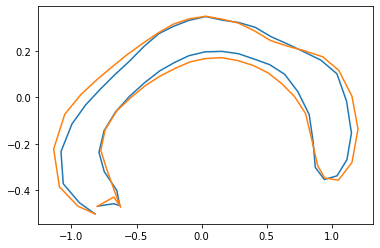

In [45]:
res_a = minimize(fun=objective_function, x0=s1, args=(a[:50], ), tol=0.01,
               options=dict([('disp', True), ('maxiter', 7)]))
plot_shape(res_a.x.reshape((-1, 2)))
res_b = minimize(fun=objective_function, x0=s1, args=(b[:50], ), tol=0.01,
               options=dict([('disp', True), ('maxiter', 7)]))
plot_shape(res_b.x.reshape((-1, 2)))

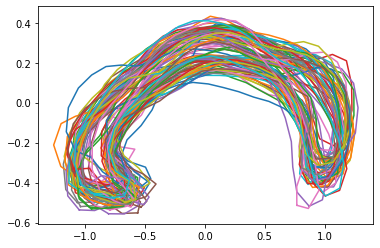

In [37]:
def plot_polygon(p):
    coords = np.array(p.exterior.coords.xy).transpose()
    plot_shape(coords)
    
for p in ps[:50]:
    plot_polygon(p)

In [77]:
a_train = a[:50]
b_train = b[:50]
train = a_train + b_train
train_labels = [0] * len(a_train) + [1] * len(b_train)

a_test = a[50:]
b_test = b[50:]
test = a_test + b_test
test_labels = [0] * len(a_test) + [1] * len(b_test)

avg_a = res_a.x
avg_b = res_b.x
pol_a = Polygon(avg_a.reshape((-1, 2)))
pol_b = Polygon(avg_b.reshape((-1, 2)))
                

print(objective_function(avg_a, a_test))
print(objective_function(avg_a, b_test))
print(objective_function(avg_b, a_test))
print(objective_function(avg_b, b_test))



0.21175699311084095
0.2604151197296837
0.26377437503098594
0.22378758755859582


In [96]:
def dist(x, y):
    return area_dist(Polygon(x.reshape((-1, 2))), Polygon(y.reshape((-1, 2))))

def predict(res_a, res_b, x):
    return [0 if area_dist(pol_a, p) < area_dist(pol_b, p) 
            else 1 for p in x]

print(accuracy_score(test_labels, y_pred=predict(res_a, res_b, test)))

0.7395498392282959


In [83]:
from sklearn.manifold import MDS
train = a_train + b_train
train2 = train + [pol_a, pol_b]
dists2 = np.array([[area_dist(p, q) for p in train2] for q in train2])

In [84]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
embs = embedding.fit_transform(dists2)

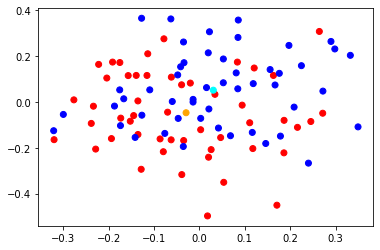

In [85]:
color_dict = {0: 'red', 1: 'blue', 2: 'orange', 3: 'cyan'}
pp.scatter(embs[:, 0], embs[:, 1], color=[color_dict[i] for i in train_labels + [2, 3]])

In [102]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

a = load_data('corpus_callosum/altzheimers/50/')
b = load_data('corpus_callosum/healthy/50/')
a_train = a[:50]
b_train = b[:50]
train = np.concatenate((a_train, b_train))
train_labels = [0] * len(a_train) + [1] * len(b_train)

a_test = a[50:]
b_test = b[50:]
test = np.concatenate((a_test, b_test))
test_labels = [0] * len(a_test) + [1] * len(b_test)

neigh = KNeighborsClassifier(n_neighbors=3, metric=dist)
neigh.fit(train, train_labels)

print(accuracy_score(test_labels, neigh.predict(test)))

0.7813504823151125
